In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 108.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.9 MB/s eta 0:00:00


In [3]:
root_dir = '/gdrive/MyDrive/NLP/week10/10-2. Discourse Analysis'

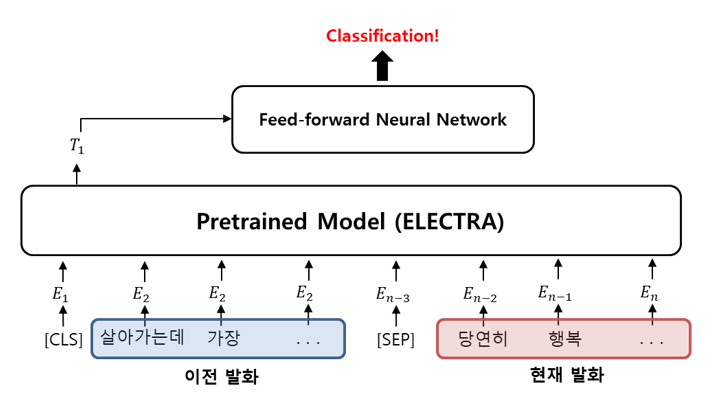

In [4]:
import os
from IPython.display import Image
Image(os.path.join(root_dir, "DiscourseAnalysis.PNG"))

In [5]:
import torch.nn as nn
from transformers import ElectraPreTrainedModel, ElectraModel

class ElectraForSequenceClassification(ElectraPreTrainedModel):
    def __init__(self, config):
        super(ElectraForSequenceClassification, self).__init__(config)

        # Electra 모델
        self.electra = ElectraModel(config)

        # 분류할 라벨의 개수
        self.num_labels = config.num_labels # num_labels는 화행의 개수 16개
        self.hidden_size = config.hidden_size

        self.dropout = nn.Dropout(config.hidden_dropout_prob) # Dropout 추가
        
        self.output_layer = nn.Linear(in_features=self.hidden_size, out_features=self.num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        
        # electra_output : (batch_size, max_length, hidden_size)
        electra_output = outputs[0]

        # cls_vector : (batch_size, hidden_size)
        cls_vector = electra_output[:, 0, :] # 그 중 cls만 가져옴

        cls_vector = self.dropout(cls_vector) # Dropout 적용 

        # outputs : (batch_size, num_labels)
        outputs = self.output_layer(cls_vector)

        return outputs


In [6]:

import torch
import numpy as np
import re
from tqdm import tqdm

def load_label_vocab(label_file):
    label2idx = {}
    idx2label = {}
    with open(label_file,'r',encoding='utf8') as infile:
        for line in infile:
            line = line.strip()
            label2idx[line] = len(label2idx)
            idx2label[len(idx2label)] = line
    return label2idx, idx2label

def read_data(file_path):
    with open(file_path, "r", encoding="utf8") as infile:
      datas = []
      for line in tqdm(infile, desc="read_data"):
          # 입력 데이터를 \t을 기준으로 분리
          pieces = line.strip().split("\t")
          last_utterance, cur_utterance, label = pieces[0], pieces[1], pieces[2]
          datas.append((last_utterance, cur_utterance, label))
    return datas

def convert_data2feature(datas, max_length, tokenizer, label2idx):
    input_ids_features, attention_mask_features, token_type_ids_features, label_id_features = [], [], [], []

    for last_utterance, cur_utterance, label in tqdm(datas, desc="convert_data2feature"):
        #########################################
        tokenized_last_utterance = tokenizer.tokenize(last_utterance)
        tokenized_cur_utterance = tokenizer.tokenize(cur_utterance)

        tokens = [tokenizer.cls_token]
        tokens += tokenized_last_utterance
        tokens += [tokenizer.sep_token]
        tokens += tokenized_cur_utterance
        tokens += [tokenizer.sep_token]
        #########################################

        # word piece들을 대응하는 index로 치환
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        # padding을 제외한 실제 데이터 정보를 반영해주기 위한 attention mask
        attention_mask = [1] * len(input_ids)
        # 각 문장을 구분하기 위한 정보를 반영해주기 위한 token type
        token_type_ids = [0] * len(input_ids)

        # padding 생성
        padding = [tokenizer._convert_token_to_id(tokenizer.pad_token)] * (max_length - len(input_ids))
        input_ids += padding
        attention_mask += padding
        token_type_ids += padding
        assert max_length == len(input_ids) == len(attention_mask) == len(token_type_ids)
        label_id = label2idx[label]

        # 변환한 데이터를 각 리스트에 저장
        input_ids_features.append(input_ids)
        attention_mask_features.append(attention_mask)
        token_type_ids_features.append(token_type_ids)
        label_id_features.append(label_id)

    # 변환한 데이터를 Tensor 객체에 담아 반환
    input_ids_features = torch.tensor(input_ids_features, dtype=torch.long)
    attention_mask_features = torch.tensor(attention_mask_features, dtype=torch.long)
    token_type_ids_features = torch.tensor(token_type_ids_features, dtype=torch.long)
    label_id_features = torch.tensor(label_id_features, dtype=torch.long)

    return input_ids_features, attention_mask_features, token_type_ids_features, label_id_features

In [7]:
import numpy as np
from tqdm import tqdm


import torch
from torch.utils.data import (DataLoader, TensorDataset, RandomSampler, SequentialSampler)
import torch.optim as optim

from transformers import ElectraPreTrainedModel, ElectraTokenizer, ElectraConfig
from sklearn.metrics import accuracy_score

def train(config):
    # Electra tokenizer 객체 생성
    electra_tokenizer = ElectraTokenizer.from_pretrained(config['pretrained_model_name_or_path'])

    # 학습 및 평가 데이터 읽기
    train_datas = read_data(config["train_data_path"])
    test_datas = read_data(config["test_data_path"])
    label2idx, idx2label = load_label_vocab(config["label_file_path"])
    # 입력 데이터 전처리
    train_input_ids_features, train_attention_mask_features, train_token_type_ids_features, train_label_id_features = \
        convert_data2feature(train_datas, config["max_length"], electra_tokenizer, label2idx)
    test_input_ids_features, test_attention_mask_features, test_token_type_ids_features, test_label_id_features = \
        convert_data2feature(test_datas, config["max_length"], electra_tokenizer, label2idx)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_input_ids_features, train_attention_mask_features, train_token_type_ids_features, train_label_id_features)
    train_dataloader = DataLoader(train_features, sampler=RandomSampler(train_features), batch_size=config["batch_size"])

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_input_ids_features, test_attention_mask_features, test_token_type_ids_features, test_label_id_features)
    test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features), batch_size=config["batch_size"])

    # 사전 학습된 Electra 모델 파일로부터 가중치 불러옴
    electra_config = ElectraConfig.from_pretrained(config['pretrained_model_name_or_path'])
    setattr(electra_config, "num_labels", config['num_labels'])
    model = ElectraForSequenceClassification.from_pretrained(config["pretrained_model_name_or_path"], config = electra_config).cuda()

    # loss를 계산하기 위한 함수
    loss_func = nn.CrossEntropyLoss()

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=5e-5)

    # 모델의 정확도를 저장하기 위한 변수
    max_accuracy = 0
    global_step=0
    for epoch in range(config["epoch"]):
        model.train()

        total_loss = []
        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.cuda() for t in batch)
            input_ids, attention_mask, token_type_ids, label_id = batch

            # 역전파 단계를 실행하기 전에 변화도를 0으로 변경
            optimizer.zero_grad()

            # 모델 예측 결과
            hypothesis = model(input_ids, attention_mask, token_type_ids)

            # loss 계산
            loss = loss_func(hypothesis, label_id)

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()
            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            # batch 단위 loss 값 저장
            total_loss.append(loss.data.item())
            if (global_step + 1) % 10 == 0:
                print("Current {} Step Loss : {}".format(global_step+1, loss))
            if (global_step+1) % 500 == 0:
                electra_config.save_pretrained(save_directory=config["output_dir_path"])
                model.save_pretrained(save_directory=config["output_dir_path"])
                max_accuracy = evaluate(model, electra_tokenizer, test_dataloader)
            global_step+=1
            # 하이퍼파라미터 중간중간 저장하는 것

def evaluate(model, tokenizer, test_dataloader=None):
    label2idx, idx2label = load_label_vocab(config["label_file_path"])
    if not test_dataloader:
        test_datas = read_data(config["test_data_path"])
        # 입력 데이터 전처리
        test_input_ids_features, test_attention_mask_features, test_token_type_ids_features, test_label_id_features = \
            convert_data2feature(test_datas, config["max_length"], tokenizer, label2idx)

        # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
        test_features = TensorDataset(test_input_ids_features, test_attention_mask_features,
                                      test_token_type_ids_features, test_label_id_features)
        test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features),
                                     batch_size=config["batch_size"])

    model.eval()
    # 모델의 출력 결과와 실제 정답값을 담을 리스트
    total_hypothesis, total_labels = [], []
    for idx, batch in enumerate(test_dataloader):
        batch = tuple(t.cuda() for t in batch)
        input_ids, attention_mask, token_type_ids, label_id = batch

        with torch.no_grad():
            # 모델 예측 결과
            hypothesis = model(input_ids, attention_mask, token_type_ids)
            # 모델의 출력값에 softmax와 argmax 함수를 적용
            hypothesis = torch.argmax(hypothesis, dim=-1) # 맨 마지막 차원으로 d

        # Tensor를 리스트로 변경
        hypothesis = hypothesis.cpu().detach().numpy().tolist()
        label_id = label_id.cpu().detach().numpy().tolist()

        total_hypothesis += hypothesis
        total_labels += label_id
        if idx < 10:
            input_ids = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
            input_sequence = tokenizer.convert_tokens_to_string(input_ids[1:input_ids.index(tokenizer.pad_token)] if tokenizer.pad_token in input_ids else input_ids[1:])
            pre_utterance, cur_utterance, _ = [e.strip() for e in input_sequence.split("[SEP]")]
            print("\nPrevious Utterance : ", pre_utterance)
            print("Current Utterance : ", cur_utterance)
            print("Prediction : ", idx2label[hypothesis[0]])
            print("Label : ", idx2label[label_id[0]], '\n\n')

    # 정확도 계산
    accuracy = accuracy_score(total_labels, total_hypothesis)
    print("Accuracy : {}".format(accuracy))
    print()
    return accuracy

In [8]:
import os
import random
import numpy as np



def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if (__name__ == "__main__"):
    save_dir = os.path.join(root_dir, "save")
    output_dir = os.path.join(root_dir, "output")
    cache_dir = os.path.join(root_dir, "cache")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    set_seed(seed=1234)

    config = {"mode": "train",
              "train_data_path": os.path.join(root_dir, "train.txt"),
              "test_data_path": os.path.join(root_dir, "test.txt"),
              "label_file_path": os.path.join(root_dir, "label.txt"),
              "output_dir_path": output_dir,
              "save_dir_path": save_dir,
              "cache_dir_path": cache_dir,
              "pretrained_model_name_or_path": 'monologg/koelectra-small-v3-discriminator',
              "max_length": 250,
              "num_labels":16, # 화행 수 
              "epoch": 30,
              "batch_size": 64,
              }

    if (config["mode"] == "train"):
        train(config)
    elif config['mode'] == 'test':
        tokenizer = ElectraTokenizer.from_pretrained(config["pretrained_model_name_or_path"])
        electra_config = ElectraConfig.from_pretrained(config["output_dir_path"])
        setattr(electra_config, "num_labels", config['num_labels'])
        model = ElectraForSequenceClassification.from_pretrained(config["output_dir_path"],
                                                                 config=electra_config).cuda()
        evaluate(model, tokenizer)


read_data: 3241it [00:00, 4623.40it/s]
read_data: 856it [00:00, 895.67it/s]
convert_data2feature: 100%|██████████| 856/856 [00:00<00:00, 2913.23it/s]


Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

Current 10 Step Loss : 2.3823347091674805
Current 20 Step Loss : 2.0779213905334473
Current 30 Step Loss : 1.9922302961349487
Current 40 Step Loss : 1.8412595987319946
Current 50 Step Loss : 1.6563944816589355
Current 60 Step Loss : 1.5915212631225586
Current 70 Step Loss : 1.673596978187561
Current 80 Step Loss : 1.8101632595062256
Current 90 Step Loss : 1.865689754486084
Current 100 Step Loss : 1.56947660446167
Current 110 Step Loss : 1.4844787120819092
Current 120 Step Loss : 1.4471317529678345
Current 130 Step Loss : 1.1957335472106934
Current 140 Step Loss : 1.2570419311523438
Current 150 Step Loss : 1.2668815851211548
Current 160 Step Loss : 1.3656551837921143
Current 170 Step Loss : 1.4578440189361572
Current 180 Step Loss : 1.108738660812378
Current 190 Step Loss : 1.2112255096435547
Current 200 Step Loss : 1.211804986000061
Current 210 Step Loss : 1.153618574142456
Current 220 Step Loss : 1.0537481307983398
Current 230 Step Loss : 0.8950648307800293
Current 240 Step Loss : 1.0

성능 개선 전 성능
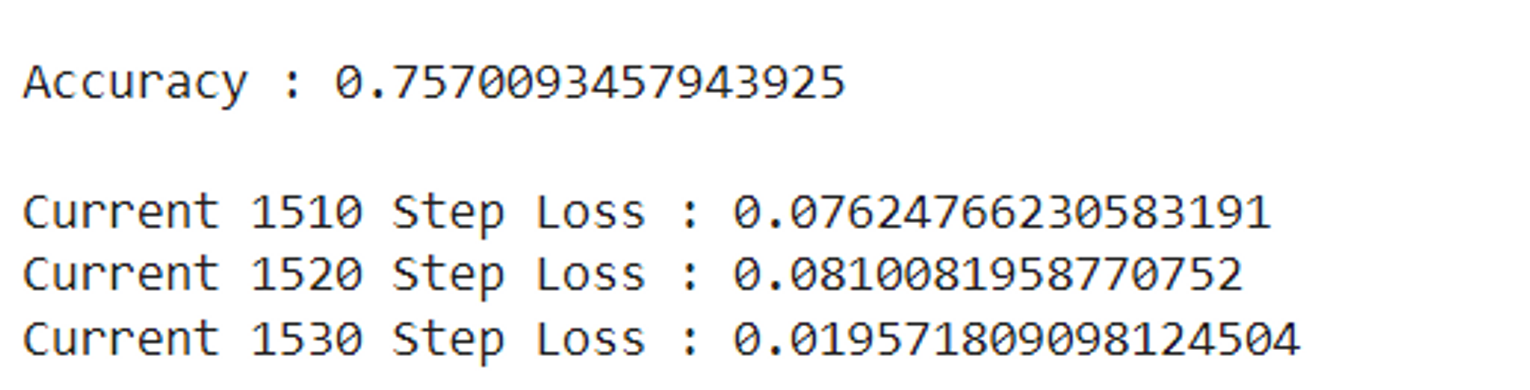

성능 개선후 성능
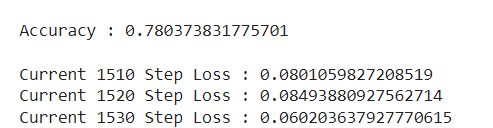

### 개선포인트 
드롭아웃 기법을 사용하여 오버피팅 방지함 
self.dropout = nn.Dropout(config.hidden_dropout_prob)  # Dropout 추가